In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x

# Set random seed
np.random.seed(0)

In [30]:
# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print(train[0])
print(labels[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0


<Figure size 432x432 with 0 Axes>

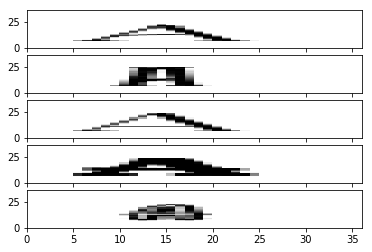

In [31]:
plt.figure(figsize=(6,6))
f, plts = plt.subplots(5, sharex=True)
c = 91

for i in range(5):
    plts[i].pcolor(train[c + i * 558],
                   cmap=plt.cm.gray_r)

In [32]:
#convert to one hot
def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[1., 0., 0., 0., 0, .0],
          [0., 1., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])
    '''
    outlabels = np.zeros((len(labels), nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

In [33]:
# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]

test, train = train[test_idx,:], train[training_idx, :]
onehot_test, onehot_train = onehot[test_idx, :], onehot[training_idx, :]

In [39]:
sess = tf.InteractiveSession()

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [40]:
# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None, 5])

# Variables
W = tf.Variable(tf.zeros([1296, 5]))
b = tf.Variable(tf.zeros([5]))

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(x,W) + b)

### End model specification, begin training code.

In [41]:
# Climb on cross-entropy (cost function, I think)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y + 1e-50, labels = y_))

# How we train (GradientDescent)
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


In [42]:
# Actually train
epochs = 1000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy
    if i % 10 == 0:
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={
            x: train.reshape([-1, 1296]),
            y_: onehot_train
        })
        train_acc[i//10] = A
        # And now the validation set
        A = accuracy.eval(feed_dict={
            x: test.reshape([-1,1296]),
            y_: onehot_test
        })
        test_acc[i//10] = A
    train_step.run(feed_dict={
        x: train.reshape([-1,1296]),
        y_: onehot_train
    })

100%|██████████████████████████████████████| 1000/1000 [00:43<00:00, 22.88it/s]


In [43]:
# Notice the accuracy flattens out
print(train_acc[-1])
print(test_acc[-1])

0.3847073018550873
0.35483869910240173


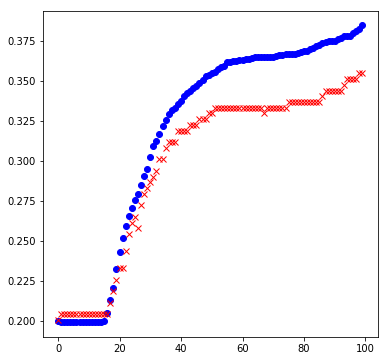

In [44]:
# Plot the accuracy curves
plt.figure(figsize=(6,6))
plt.plot(train_acc, 'bo')
plt.plot(test_acc, 'rx')

<Figure size 432x432 with 0 Axes>

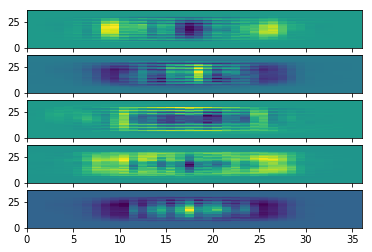

In [45]:
# Look at a subplot of the weights for each font
plt.figure(figsize=(6,6))
f, plts = plt.subplots(5, sharex=True)
for i in range(5):
    plts[i].pcolor(W.eval()[:,i].reshape([36,36]))